In [1]:
%load_ext autoreload
%autoreload 2

Load environment variables

In [2]:
import os
from dotenv import load_dotenv, find_dotenv
import warnings

warnings.filterwarnings("ignore")
_ = load_dotenv(find_dotenv())

## Initialize AgentOps
We will be using [AgentOps](https://www.agentops.ai/) to trace our session. This helps us to replay sessions and ascertain bottlenecks in our multi-agent system.
> You will need to get an API key from AgentOps - don't worry it's free-of-charge for the first 1,000 events!

In [3]:
import agentops

agentops.init(api_key=os.environ["AGENTOPS_API_KEY"])

🖇 AgentOps: Only Anthropic>=0.32.0 supported. v0.28.1 found.
🖇 AgentOps: Session Replay: https://app.agentops.ai/drilldown?session_id=d37cac85-b63c-427e-8151-88da045d00d3


# Now the fun begins!
We specify our LLM model within a dictionary stored within a `config_list`. We can add more [models into this list](https://microsoft.github.io/autogen/0.2/docs/topics/llm_configuration/). This allows for different models to be used by the agent - if any model times out, the agent will automatically try another model. We can also add a `tag` in order to pass select models into a certain agent, this allows us to choose different agents for different tasks.
> Do ensure that you have the relevant API keys in your `.env` file!

In [3]:
from autogen import (
    AssistantAgent,
    GroupChat,
    GroupChatManager,
    UserProxyAgent,
)
from autogen.cache import Cache
from autogen.coding import LocalCommandLineCodeExecutor

from datetime import datetime

config_list=[
    {"model": "gpt-4o-mini", "api_key": os.environ["OPENAI_API_KEY"]}
]

## Defining our task

In [5]:
task = (
    f"Today is {datetime.now().date()}. Write a blogpost about the stock price performance of Illumina in the past month."
)
print(task)

Today is 2024-11-02. Write a blogpost about the stock price performance of Illumina in the past month.


## The Group Chat
Autogen has an amazing abstraction for multi-agent systems known as `GroupChat`s. Of course you don't have to use this abstraction. For smaller agent systems you could simply just tell one agent to ping a specific system. For complex questions, you could even use [nested chats](https://microsoft.github.io/autogen/0.2/docs/notebooks/agentchat_nestedchat) or even [nest a chat within a group chat](https://microsoft.github.io/autogen/0.2/docs/notebooks/agentchat_nested_sequential_chats).

Autogen has many amazing examples!
> Nested chats are a sequence of chats created by a receiver agent after receiving a message from a sender agent and finished before the receiver agent replies to this message. These allow AutoGen agents to use other agents as their inner monologue to accomplish tasks.

## Defining our agents
In this example we will have a total of 6 agents including 1 `GroupChatManager`. Each agent is easy to define and has a specific task. Importantly, any Autogen abstraction **must** always have at least one `UserProxyAgent`. This agent is the "proxy" of a human - i.e. it "acts on our behalf". 

Let's see how everything comes together

In [6]:
## This is us!
user_proxy = UserProxyAgent(
    name="Admin",
    system_message="A human admin. Give the task and send instructions to writer to refine the blog",
    code_execution_config=False
)

## The agents
planner = AssistantAgent(
    name="Planner",
    system_message="""You are a planner. Given a task, please determine what information is needed
    to complete the task. Do note that all the information will be retrieved using Python code, so 
    only give suggestions that can be retrieved by Python code.""",
    llm_config={"config_list": config_list, "cache_seed": None},
)

engineer = AssistantAgent(
    name="Engineer",
    llm_config={"config_list": config_list, "cache_seed": None},
    system_message="""You are a software engineer. You write python/bash to retrieve relevant 
    information. Wrap the code in a code block that specifies the script type. The user cannot
    modify your code so do not suggest incomplete code. Do not use a code block if it's not intended
    to be executed. Don't include multiple code blocks in one response. Do not ask others to copy
    and paste the result. Check the execution result returned by the executor. If the result
    indicates that there is an error, fix the error and output the code again. Suggest the full code
    instead of partial code or code changes. If the error can't be fixed or if the task is not 
    solved even after the code is successfully executed, analyze the problem, revisit your assumptions,
    collec additional info you need, and think of a different approach to try."""
)

writer = AssistantAgent(
    name="Writer",
    llm_config={"config_list": config_list, "cache_seed": None},
    system_message="""You are a writer. Please write blogs in markdown format (with relevant titles)
    and put them in pseudo ```md``` code blocks. You will write it for a task based on previous chat
    history. Don't write any code.""",
)

if not os.path.exists("blogs"):
    os.makedirs("blogs")

code_executor = UserProxyAgent(
    name="Executor",
    system_message="You are a code executor. Execute the code written by the engineer and report the result.",
    description="Executor should always be called after the engineer has written code to be executed.",
    human_input_mode="ALWAYS",
    code_execution_config={
        "last_n_messages": 3,
        "executor": LocalCommandLineCodeExecutor(work_dir="blogs")
    }
)

**Hey wait a minute!**

We have 2 `UserProxyAgent`s! One of them has a `human_input_mode` argument flag set to `"ALWAYS"`. This means that this agent will ping us for our input (i.e. our agreement) to the direction of the `GroupChat` before proceeding with its task, which in this case is to execute code in our local command line.

Also, most of the time spent above was to **write English**, not code! We wrote very comprehensive (full of instructions) `system_message`s that encompass different scenarios that the agent might face. Autogen really makes it that easy to define agents, the emphasis is on the developers to write very good prompts. Thanks to Autogen, we very quickly defined 6 different agents - including one with the ability to execute code in our local command line.

> Note the `description` field in the code_executor agent. This is an optional argument that is used by the `GroupChatManager` to decide on when to call this agent. Once again this can be written in English, **not code**!

In [7]:
groupchat = GroupChat(
    agents = [user_proxy, engineer, code_executor, writer, planner],
    messages=[],
    max_round=20,
    speaker_selection_method="auto"
)

manager = GroupChatManager(
    groupchat=groupchat,
    llm_config={"config_list": config_list, "cache_seed": None}
)

Defining our `GroupChat` is even easier! Just define the agents in a list and set a few important arguments. These arguments are:
1. `max_round`: As you can imagine, with human feedback and the complexity of some questions we ask, we could go many rounds within the group chat which will be very costly (LLM-wise). This argument allows for the `GroupChat` to automatically terminate once we've reached the limit.
2. `speaker_selection_method`: This is a very important arugment. If your agent `description` fields are well written, you could set this to "auto", which essentially means that the `GroupChatManager` has full control over which speaker goes next. The other methods are:
    - "random": The next speaker is selected at random.
    - "round_robin": All agents must speak. The next speaker is selected in a round robin fashion - iterating in the same order as provided in the `agents` input list to the `GroupChat` object.
    - "manual": The user (i.e. us) will have to manually select the next speaker.
    - Callable:  A custom function. If we desire lower level control, we can pass in a function that defines our [customized speaker selection method](https://microsoft.github.io/autogen/0.2/docs/notebooks/agentchat_groupchat_customized/).
3. `allowed_or_disallowed_speaker_transitions` [Dict[str, List[str]]]: We did not set this because there are no specific allowed/disallowed transitions that we need to specify. But if we want to we can also specify this as a dictionary!

We've selected "auto", which means that the `GroupChatManager` has full control on when to terminate the conversation. Do note that the `GroupChatManager` also has an `llm_config` requirement that specifies which LLM it should use.

In [8]:
## Cache LLM response
with Cache.disk(cache_seed=41) as cache:
    chat_history = user_proxy.initiate_chat(
        manager,
        message=task,
        cache=cache
    )

Admin (to chat_manager):

Today is 2024-11-02. Write a blogpost about the stock price performance of Illumina in the past month.

--------------------------------------------------------------------------------

Next speaker: Planner

Planner (to chat_manager):

To write a blog post about the stock price performance of Illumina in the past month, you will need the following information, which can be retrieved using Python code:

1. **Historical Stock Prices**: 
   - Retrieve the stock price data for Illumina (ticker symbol: ILMN) for the past month (from 2024-10-02 to 2024-11-02).

2. **Price Changes**:
   - Calculate the percentage change in the stock price over the month.
   - Identify the highest and lowest stock prices during this period.

3. **Trading Volume**:
   - Get the average trading volume for Illumina over the past month.

4. **Market Trends**:
   - Analyze any significant news or events related to Illumina during the past month that may have influenced stock performance.


Once the group chat commences, the UserProxyAgent approaches the `GroupChatManager` with the task. The `GroupChatManager` then approaches the `Planner` agent to develop a plan that can answer the user's question. The output is returned to the `GroupChatManager` who approaches the `Engineer` agent to develop Python scripts to acquire the information needed. The `Engineer` writes the script, hands it to the `GroupChatManager` who routes it to the `CodeExecutor` agent, which is another `UserProxyAgent` that will seek for our feedback (because `human_input_mode` is set to "ALWAYS"). 
1. I corrected myself and said I would like it for the past 12 months instead of the past month. This input gets routed to the `GroupChatManager` who then approaches the `Engineer` instead of the `Planner` agent as before - it deems that the previous plan would work to answer this question as well.
2. The `Engineer` rewrites the code, submits it to the `CodeExecutor` who approaches us again. This time I had no input so I just hit the "Enter" button which invokes Autogen's "AUTO REPLY" - you could also just type "OK". 
3. This causes the `CodeExecutor` agent to execute the code written by the `Engineer`, and passes the results to the `GroupChatManager` who selects the `Writer` agent to write a report.
4. The `Writer` agent's report is sent to the `GroupChatManager` who routes it to the `UserProxyAgent` (us) for feedback. I added that I would like to have "Buy/sell/hold" recommendations which was then routed by the `GroupChatManager` back to the `Writer` agent. Notice here that it could have routed to the `Planner` agent to redevise a new approach but it did not - it deemed that the current information on-hand was sufficient to answer the question.
5. The `Writer` agent re-writes the report to add the recommendations and this is surfaced to us for approval again. Since I had no further feedback and was satisfied with the reply, I typed "exit" which ended the conversation.

> Do note that typing 'exit' is the only way to terminate an Autogen conversation (aside from the maximum rounds).

In [9]:
from IPython.display import display, Markdown

In [10]:
display(Markdown(chat_history.chat_history[-1]['content']))

```md
# Illumina's Stock Performance: A Year in Review

As of November 2, 2024, we take a closer look at the stock performance of Illumina (ticker symbol: ILMN) over the past 12 months. The analysis reveals significant movements and trends that provide insights into the company's market behavior.

## Key Financial Metrics

### Starting and Ending Prices
- **Start Price (November 2023):** $113.74
- **End Price (November 2024):** $149.76

Illumina's stock began the year at approximately $113.74 and finished at $149.76, showcasing a robust recovery and growth over the year.

### Percentage Change
- **Percentage Change:** 31.67%

This signifies a substantial increase in Illumina's stock value, indicating strong investor confidence and possibly favorable market conditions affecting the company.

### Price Fluctuations
- **Highest Price:** $149.76
- **Lowest Price:** $90.26

The stock witnessed considerable volatility, with a low of $90.26, reflecting the dynamic nature of the biotech sector in which Illumina operates. The peak price of $149.76 at year-end points to a strong bullish sentiment among investors.

### Trading Volume
- **Average Trading Volume:** 2,200,726 shares

A high trading volume suggests significant interest in Illumina's stock, indicating that investors are actively participating in trading, whether for speculation or long-term investment strategies.

## Market Context and Trends

Several factors may have influenced Illumina's stock performance over the past year. The company is a leader in genomic sequencing technologies and has been at the forefront of innovations in health care and personalized medicine. Additionally, industry-wide trends such as increased demand for genetic testing and advancements in genomic research may have contributed to the strong stock performance.

## Recommendation: Buy, Sell, or Wait?

Considering the strong upward trajectory of Illumina's stock over the past year, potential investors might consider the following:

- **Buy:** If you are a long-term investor looking to capitalize on the ongoing advancements in genomics and personalized medicine, purchasing Illumina shares at current levels could be a prudent choice, especially given their trend of innovation and market position.

- **Sell:** If you are a short-term trader who has already realized substantial gains from the recent price increase, it might be wise to take profits and consider selling, particularly if you observe signs of volatility or any market corrections.

- **Wait:** If you are unsure about the sustainability of the price increase or if valuation metrics seem stretched, it may be advisable to wait for a more favorable entry point. Keeping an eye on market trends, upcoming earnings reports, and any potential regulatory changes in the biotech sector could provide valuable insights.

## Conclusion

The last 12 months have been transformative for Illumina’s stock. The impressive growth in share price, coupled with significant trading activity, indicates a positive market reception of the company's ongoing initiatives and the broader trends within the biotech sector.

As we move into the next year, investors will closely watch not only Illumina's financial metrics but also the company's strategies in response to the rapid advancements in genomics and personalized medicine.

Stay tuned for more updates on Illumina and other major players in the biotechnological landscape.
```

And finally we terminate the session on agentops. Nice! We spent less than USD 0.01 on this. How cool is that!

In [11]:
agentops.end_session("Success")

🖇 AgentOps: Session Stats - Duration: 1m 22.3s | Cost: $0.006681 | LLMs: 26 | Tools: 0 | Actions: 136 | Errors: 0
🖇 AgentOps: Session Replay: https://app.agentops.ai/drilldown?session_id=d37cac85-b63c-427e-8151-88da045d00d3


In [3]:
import markdown

# Specify the markdown file
file_name = "report.md"

# Open and read the markdown file content
with open(file_name, "r") as file:
    markdown_text = file.read()

# Convert markdown to HTML
html = markdown.markdown(markdown_text)

# Display the HTML (for example, in a Jupyter Notebook)
from IPython.display import display, HTML
display(HTML(html))

## Viewing AgentOps Logs
Here's an example of a view from the AgentOps software. We can get "Session Replay" and view every step at milisecond latency level to triage bottlenecks and issues.

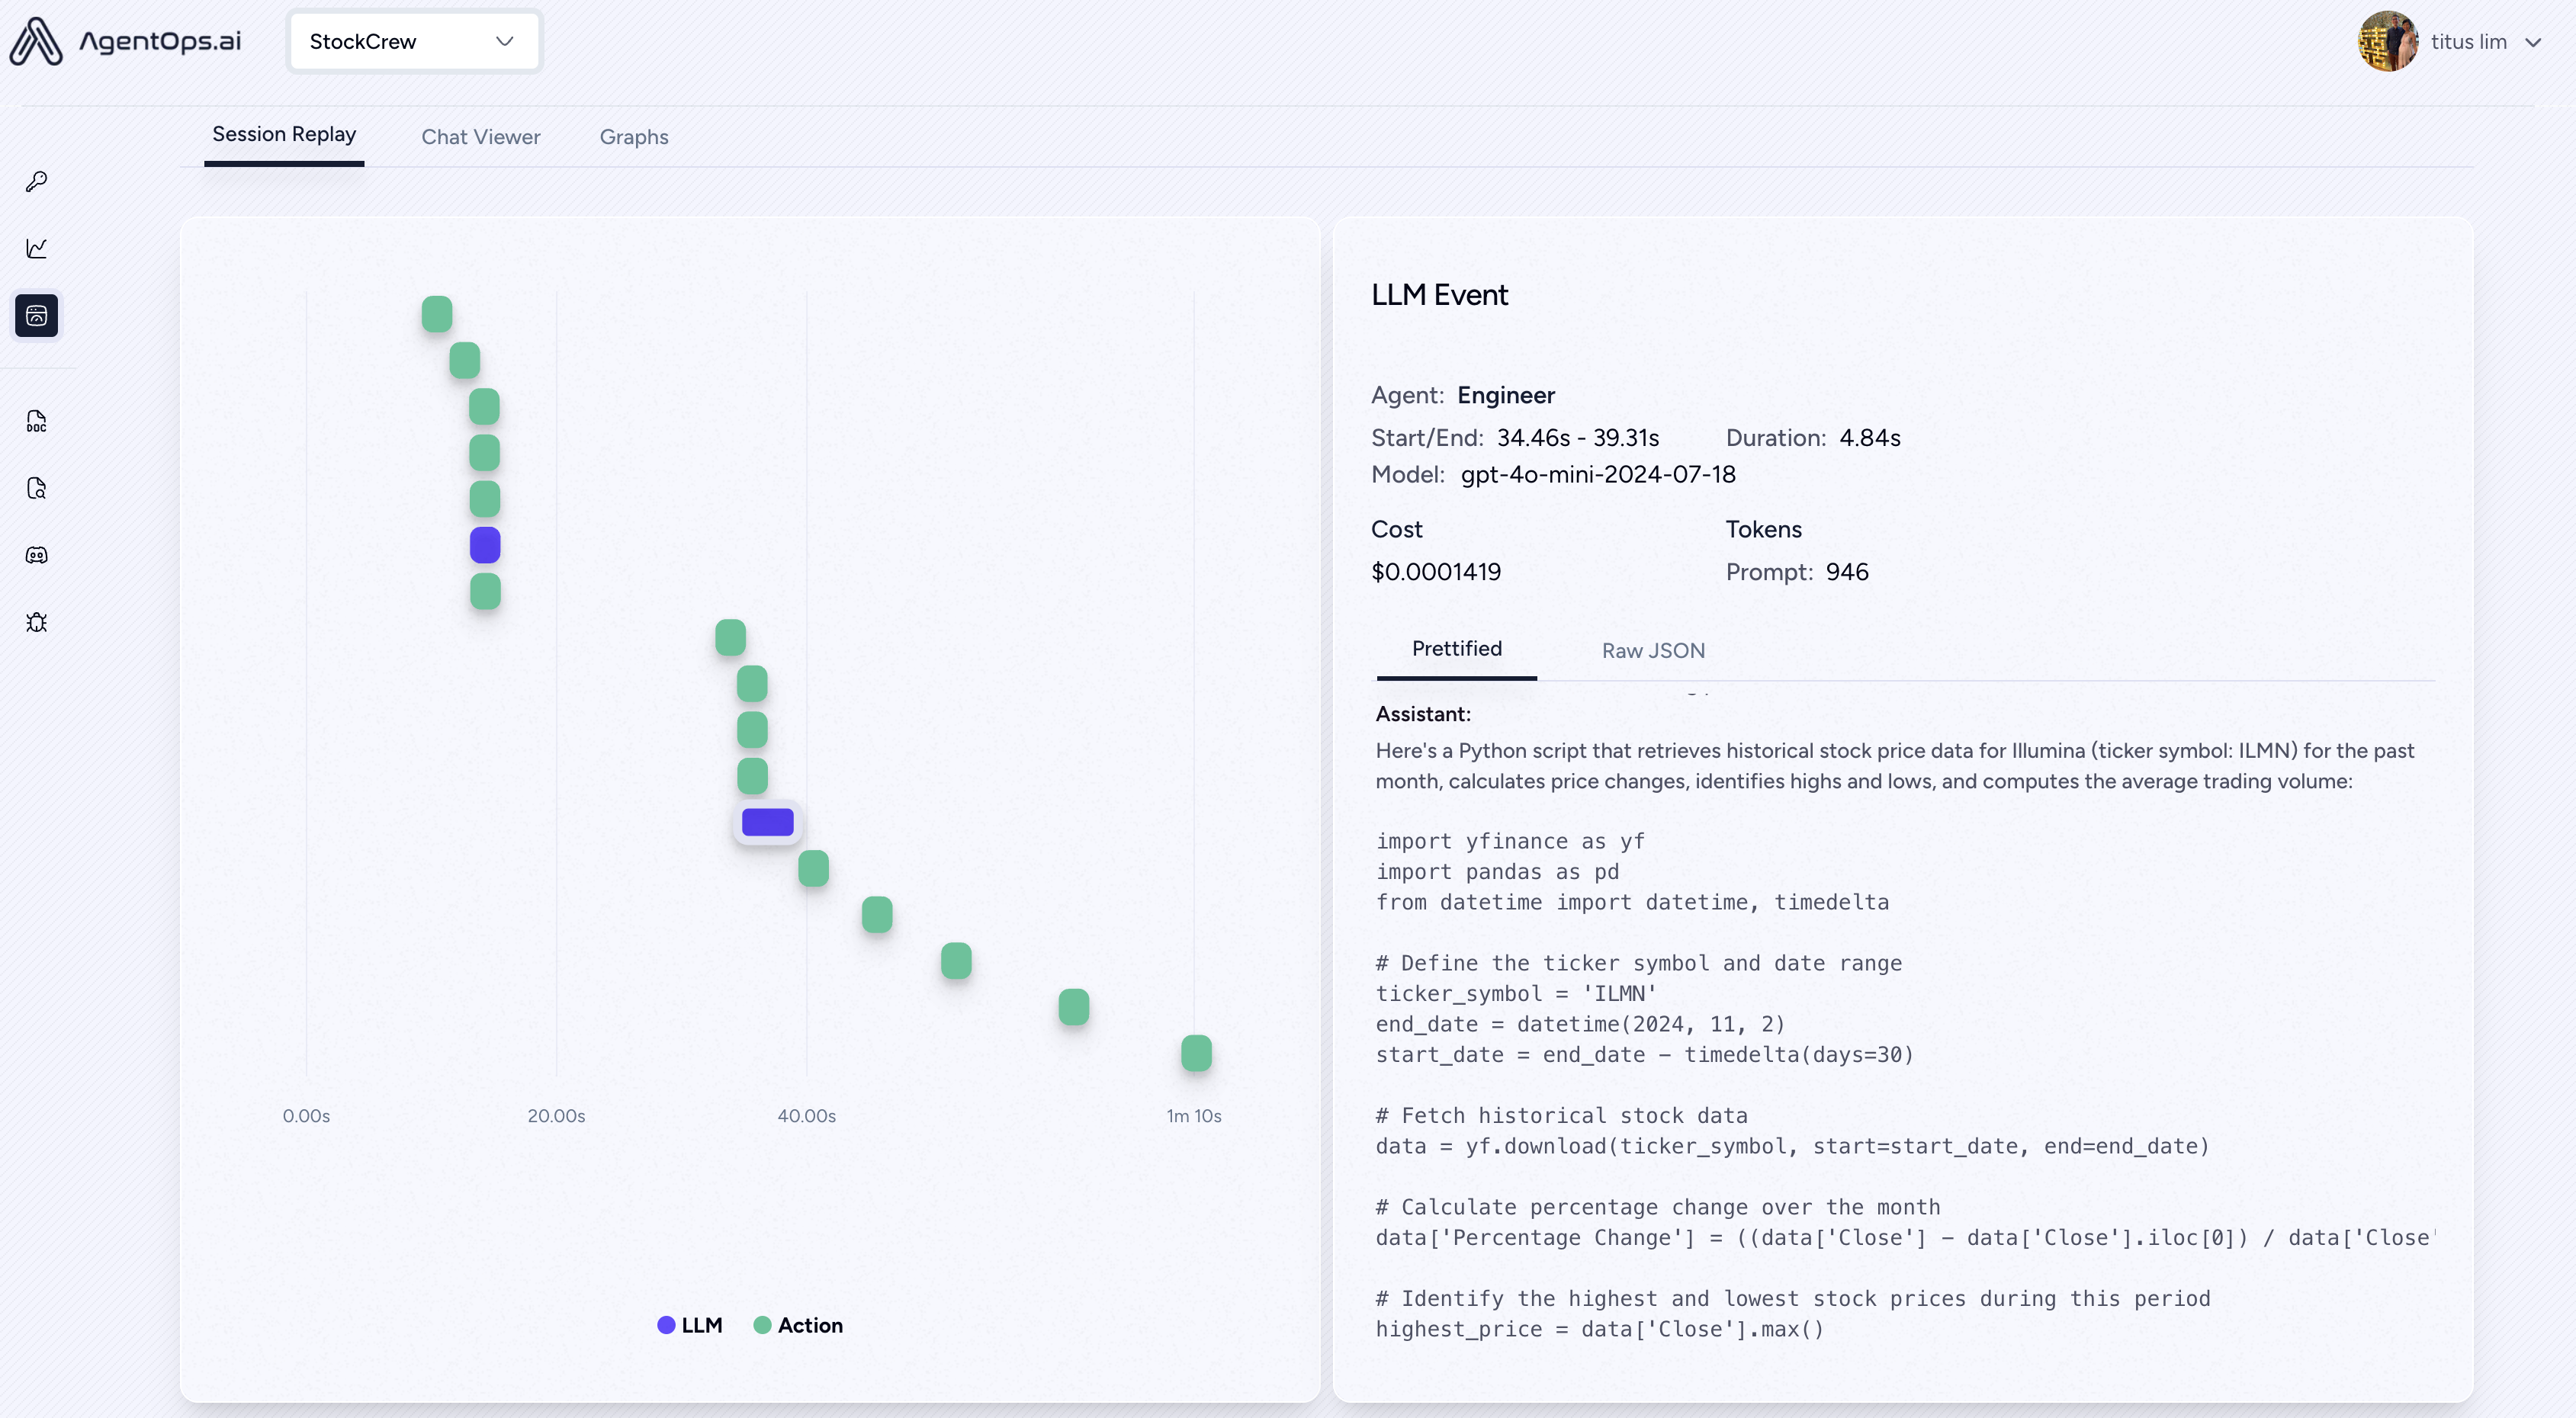

In [4]:
from PIL import Image

Image.open("agentops_screenshot.png")

# Alternatively
If we already know the task that we want to do. We can simplify the `GroupChat` approach into a 2 agent approach with tool calling.

In [10]:
import agentops

agentops.init(api_key=os.environ["AGENTOPS_API_KEY"])

🖇 AgentOps: Session Replay: https://app.agentops.ai/drilldown?session_id=7e7ccfbd-f09a-4c4f-b7c9-8ec64776b6e9


In [6]:
user_proxy = UserProxyAgent(
    name="Admin",
    system_message="A human admin. Give the task and send instructions to writer to refine the blog",
    is_termination_msg=lambda x: x.get("content", "") and x.get("content", "").rstrip().endswith("TERMINATE"),
    human_input_mode="NEVER",
    max_consecutive_auto_reply=10,
    code_execution_config=False
)

assistant = AssistantAgent(
    name="Assistant",
    system_message="""You are a helpful assistant. Only use the functions you are provided with. 
    Reply TERMINATE when the task is done""",
    llm_config={"config_list": config_list, "cache_seed": None}
)

In [12]:
from typing import Annotated, Optional, Dict, Any
from datetime import datetime, timedelta
import yfinance as yf

@user_proxy.register_for_execution()
@assistant.register_for_llm(description="Gets stock data for ticker of interest")
async def get_stock_data(
    ticker: Annotated[str, "Ticker of interest"],
    end_date: Optional[str] = datetime.now().strftime("%Y-%m-%d"),
    start_date: Optional[str] = None
) -> Dict[str, Any]:
    end_date = datetime.strptime(end_date, "%Y-%m-%d")
    if start_date is None:
        start_date = end_date - timedelta(days=365)
    data = yf.download(ticker, start=start_date, end=end_date)
    # Calculate percentage change over the 12 months
    data['Percentage Change'] = ((data['Close'] - data['Close'].iloc[0]) / data['Close'].iloc[0]) * 100

    # Identify the highest and lowest stock prices during this period
    highest_price = data['Close'].max()
    lowest_price = data['Close'].min()

    # Calculate average trading volume
    average_volume = data['Volume'].mean()

    # Prepare results
    result = {
        'start_price': data['Close'].iloc[0],
        'end_price': data['Close'].iloc[-1],
        'percentage_change': data['Percentage Change'].iloc[-1],
        'highest_price': highest_price,
        'lowest_price': lowest_price,
        'average_volume': average_volume
    }
    return result

In [14]:
from autogen import Cache

with Cache.disk() as cache:
    chat_history = await user_proxy.a_initiate_chat(
        assistant,
        message="Write a blogpost about the stock price performance of Illumina for the past year.",
        cache=cache,
    )

Admin (to Assistant):

Write a blogpost about the stock price performance of Illumina for the past year.

--------------------------------------------------------------------------------
Assistant (to Admin):

***** Suggested tool call (call_PEfchwT4U1JvSPbvKJO9rqmE): get_stock_data *****
Arguments: 
{"ticker":"ILMN","start_date":"2023-10-02","end_date":"2024-10-02"}
*******************************************************************************

--------------------------------------------------------------------------------

>>>>>>>> EXECUTING ASYNC FUNCTION get_stock_data...


[*********************100%***********************]  1 of 1 completed

Admin (to Assistant):

Admin (to Assistant):

***** Response from calling tool (call_PEfchwT4U1JvSPbvKJO9rqmE) *****
{"start_price": 132.72373962402344, "end_price": 128.97999572753906, "percentage_change": -2.8207040481902945, "highest_price": 143.19065856933594, "lowest_price": 90.26264953613281, "average_volume": 2200936.1666666665}
**********************************************************************

--------------------------------------------------------------------------------
Assistant (to Admin):

### Blog Post: Analyzing the Stock Price Performance of Illumina Over the Past Year

Over the past year, Illumina (NASDAQ: ILMN), a leader in the field of genomics and biotechnology, has experienced a notable fluctuation in its stock price. As of October 2, 2024, the stock opened at approximately $132.72 and closed at around $128.98, marking a decrease of about 2.82%. This decline raises several questions about the factors influencing the company's performance and its position in t

In [21]:
from IPython.display import display, Markdown

display(Markdown(chat_history.chat_history[-1]['content']))

### Blog Post: Analyzing the Stock Price Performance of Illumina Over the Past Year

Over the past year, Illumina (NASDAQ: ILMN), a leader in the field of genomics and biotechnology, has experienced a notable fluctuation in its stock price. As of October 2, 2024, the stock opened at approximately $132.72 and closed at around $128.98, marking a decrease of about 2.82%. This decline raises several questions about the factors influencing the company's performance and its position in the market.

#### Price Fluctuations

Throughout the year, Illumina's stock exhibited significant volatility. The highest price reached during this period was $143.19, while the lowest point was recorded at $90.26. This range reflects the market's varying sentiments towards the company's business operations, competitive landscape, and developments in the biotechnology sector.

#### Trading Volume

The average trading volume for Illumina's stock was about 2.2 million shares per day over the year, indicating a healthy level of investor interest and activity. High trading volume often points to heightened market interest, which can be attributed to the company's announcements, earnings reports, and industry developments.

#### Market Context

To fully understand Illumina's stock performance, it is essential to consider the broader market conditions and industry trends. Throughout the past year, the biotech sector has faced challenges such as regulatory pressures, competition from emerging technologies, and changing healthcare policies. These factors often contribute to investor caution, which may have influenced Illumina's stock price.

#### Future Outlook

As we look ahead, investors are eager to see how Illumina adapts to ongoing challenges and harnesses opportunities for growth. The company’s advancements in genomics technology and potential new products could play a crucial role in its stock performance in the future. 

In conclusion, Illumina's stock price has seen a slight decline over the past year, despite reaching significant highs. Investors and analysts alike will be closely monitoring developments within the company and the broader biotech landscape as they gauge the potential for recovery and growth moving forward.

TERMINATE

In [22]:
agentops.end_session("Success")

🖇 AgentOps: Session Stats - Duration: 5m 31.3s | Cost: $0.000017 | LLMs: 4 | Tools: 2 | Actions: 9 | Errors: 0
🖇 AgentOps: Session Replay: https://app.agentops.ai/drilldown?session_id=7e7ccfbd-f09a-4c4f-b7c9-8ec64776b6e9


Look at that! We spent even less than the first attempt!